# https://www.kaggle.com/c/tt-GameLevel/data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/sample_data/train.csv')
df.head(n=10)

,Unnamed: 0,player_0,player_1,player_2,player_3,player_4,level_0,level_1,level_2,level_3,level_4,level_5,age,duration_ms,# tries,target
0,5204,0.025087,0.029495,3.361538e-06,0.007414,1.915486,0.002375,0.472284,0.021519,0.503860,11.0,1.0,15.0,215793.80,15,5
1,5175,0.024538,0.016962,2.842308e-06,0.004231,1.967912,0.001115,0.541616,0.005808,0.557895,NaN,0.0,20.0,271493.00,1,8
2,638,0.018192,0.017910,0.000000e+00,0.003359,1.953176,0.001296,0.456985,0.016872,0.596491,6.0,1.0,21.0,240264.00,6,3
3,6733,0.020673,0.020808,1.780798e-02,0.006423,1.998824,0.001202,0.507592,0.009712,0.615789,9.0,1.0,17.0,277560.50,4,8
4,2706,0.026192,0.032269,3.923077e-08,0.001815,2.108529,0.001269,0.489113,0.024154,0.410526,NaN,0.0,15.0,260773.00,1,9
5,4205,0.013000,0.012769,0.000000e+00,0.006423,2.206382,0.001585,0.452478,NaN,0.378947,6.0,0.0,NaN,348667.00,2,8
6,12107,0.024542,0.011223,7.460173e-03,0.007803,2.261897,0.001732,0.464029,NaN,NaN,7.0,1.0,25.0,238614.85,40,8
7,143,0.012500,0.007731,0.000000e+00,0.003758,2.105735,0.001085,0.375989,0.006615,0.694737,6.0,0.0,26.0,223893.00,1,6
8,8589,0.014538,0.008308,0.000000e+00,0.005808,2.126353,0.001346,0.434572,0.004769,0.368421,8.0,1.0,28.0,163893.00,2,7
9,2041,0.029564,0.020939,6.239513e-03,0.012358,2.154179,0.001822,0.498916,0.027349,0.350877,11.0,1.0,16.0,311633.25,12,9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7551 entries, 0 to 7550
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7551 non-null   int64  
 1   player_0     7551 non-null   float64
 2   player_1     7551 non-null   float64
 3   player_2     7551 non-null   float64
 4   player_3     7551 non-null   float64
 5   player_4     7551 non-null   float64
 6   level_0      7077 non-null   float64
 7   level_1      7043 non-null   float64
 8   level_2      6791 non-null   float64
 9   level_3      7277 non-null   float64
 10  level_4      6732 non-null   float64
 11  level_5      6967 non-null   float64
 12  age          5300 non-null   float64
 13  duration_ms  7551 non-null   float64
 14  # tries      7551 non-null   int64  
 15  target       7551 non-null   int64  
dtypes: float64(13), int64(3)
memory usage: 944.0 KB


- player_XXX - anonymized player metadata (how much overall time player spent in the game? how much points player collected? etc.)
- level_XXX - anonymized gameplay metadata (how much points player collected during this level? how much HP player lost during this level? etc.)
- age - age of the player (years)
- duration_ms - duration of the last (successful) try
- tries - number of tries it took to finish this level

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def fill_missed_values(original_data):
    
    new_data = original_data.copy()

    cols_with_missing = (col for col in new_data.columns 
                                     if new_data[col].isnull().any())
    for col in cols_with_missing:
        new_data[col + '_was_missing'] = new_data[col].isnull()
    real_columns = new_data.columns
    
    imputer = IterativeImputer(initial_strategy='mean', random_state=42)
    new_data = pd.DataFrame(imputer.fit_transform(new_data), columns=real_columns)
    
    return new_data

In [5]:
from sklearn.preprocessing import StandardScaler

df.duration_ms = StandardScaler().fit_transform(df.duration_ms.values.reshape(-1,1))
df = fill_missed_values(df)

features = ['level_4', 'level_5', 'age', '# tries', 'target', 'level_0_was_missing',
            'level_1_was_missing', 'level_2_was_missing', 'level_3_was_missing', 
            'level_4_was_missing', 'level_5_was_missing', 'age_was_missing']

for feature in features:
    df[feature] = df[feature].astype(np.int64)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7551 entries, 0 to 7550
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           7551 non-null   float64
 1   player_0             7551 non-null   float64
 2   player_1             7551 non-null   float64
 3   player_2             7551 non-null   float64
 4   player_3             7551 non-null   float64
 5   player_4             7551 non-null   float64
 6   level_0              7551 non-null   float64
 7   level_1              7551 non-null   float64
 8   level_2              7551 non-null   float64
 9   level_3              7551 non-null   float64
 10  level_4              7551 non-null   int64  
 11  level_5              7551 non-null   int64  
 12  age                  7551 non-null   int64  
 13  duration_ms          7551 non-null   float64
 14  # tries              7551 non-null   int64  
 15  target               7551 non-null   i

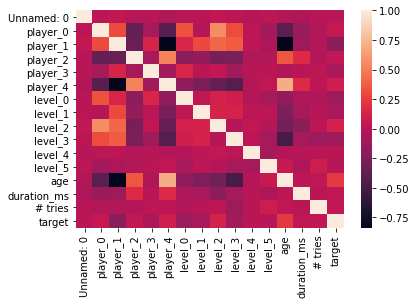

In [7]:
sns.heatmap(df.iloc[:, :16].corr())

In [8]:
X = df.drop(['Unnamed: 0', 'player_1'], axis=1)
y = df.player_1

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [10]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import StackingRegressor

In [11]:
reg = StackingRegressor(
    estimators=[('ridge', Ridge()), 
                ('lasso', Lasso()), 
                ('elastic', ElasticNet())]
)

In [12]:
%%time
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

CPU times: user 184 ms, sys: 236 ms, total: 419 ms
Wall time: 246 ms


In [13]:
reg.named_estimators

{'elastic': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 'lasso': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=None,
       selection='cyclic', tol=0.0001, warm_start=False),
 'ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001)}

In [14]:
reg.final_estimator_.coef_

array([8.11772410e-01, 9.15631328e-06, 9.15631328e-06])

In [15]:
reg.estimators_[0].coef_

array([-2.09577749e-02,  2.65006767e-02,  1.30780035e-02, -2.64640799e-02,
       -1.07485700e-03,  4.24313837e-03,  3.20649118e-02, -4.69133338e-03,
        1.71327074e-05, -8.32906703e-05, -9.98441329e-04, -1.74726346e-04,
       -1.46812806e-05, -1.22871429e-04, -2.39035001e-04,  3.35234124e-04,
        4.32766081e-05,  2.28218818e-04,  3.57532161e-04, -6.55905582e-05,
       -4.93557039e-04])

In [16]:
# !pip install eli5
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(reg, random_state=42).fit(X_test, y_test)
# eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [17]:
from sklearn.metrics import mean_squared_error as mse
mse(y_test, y_pred)

1.769777798686584e-05

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Linear Prediction of player_1 feature')

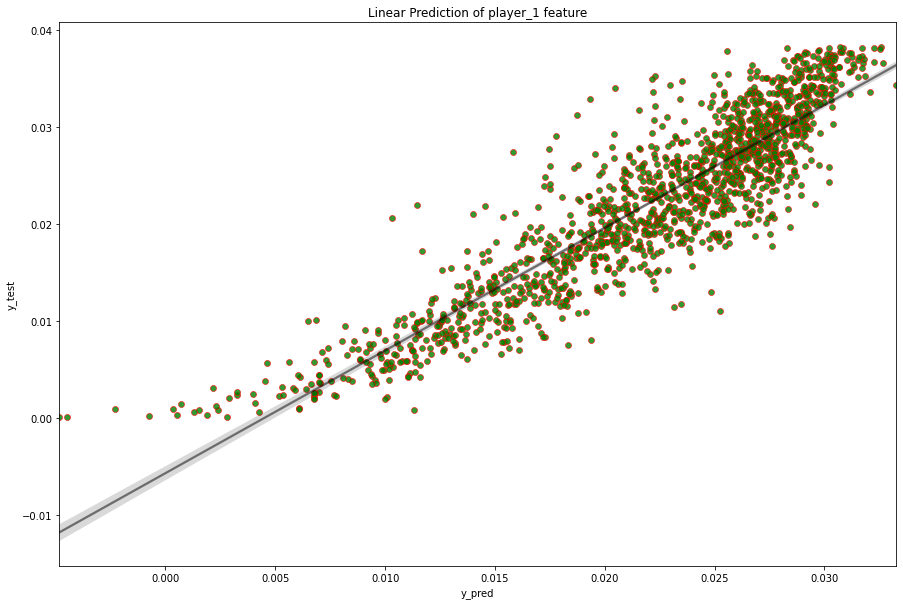

In [18]:
plt.figure(figsize=(15,10))
sns.regplot(y_pred, y_test, scatter_kws={'color':'green','edgecolor':'red','linewidth':'0.7'}, 
            line_kws={'color':'black','alpha':0.5})
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title("Linear Prediction of player_1 feature")